# Calculate Athlete Performance based on Strava History
This notebook tests different approches to use the athlete's history to predict his performance.

## Set Strava API user token
Import the Client from the [stravalib library](https://github.com/hozn/stravalib/) and set your Access Token available at https://www.strava.com/settings/api.

In [1]:
from stravalib import unithelper
from stravalib.client import Client as StravaClient

strava_client = StravaClient(access_token='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')


## Import Activities


In [2]:
import datetime
import sys
from termcolor import colored

thirty_weeks = datetime.timedelta(weeks=30)

args = {
    # 'after': datetime.datetime.now() - thirty_weeks, # start date is after specified value (UTC). datetime.datetime or str or None
    # 'before': datetime.datetime(year=2017, month=12, day=31), # start date is before specified value (UTC). datetime.datetime or str or None
    # 'limit': 50,  # Maximum activites retrieved
}

activities = strava_client.get_activities(**args)

manual_activities = [activity for activity in activities if activity.manual]
activities = [activity for activity in activities if not activity.manual]

message = "%d Activities imported\n" % len(activities)
sys.stdout.write(colored(message, attrs=['bold']))
print("%d Manual activities excluded" % len(manual_activities))


252 Activities imported
1 Manual activities excluded


## Group Activities by Activity Type
We create a dictionnary containing lists of activities by [activity type](https://strava.github.io/api/v3/activities/#activity-types-a-idtypesnbspa).


### Basic Activity Types:
- `Ride`
- `Run`
- `Swim`
- `Hike`
- `Walk`

### More Exotic ones:
`AlpineSki`, `BackcountrySki`, `Canoeing`, `Crossfit`, `EBikeRide`, `Elliptical`, `IceSkate`, `InlineSkate`, `Kayaking`, `Kitesurf`, `NordicSki`, `RockClimbing`, `RollerSki`, `Rowing`, `Snowboard`, `Snowshoe`, `StairStepper`, `StandUpPaddling`, `Surfing`, `VirtualRide`, `WeightTraining`, `Windsurf`, `Workout`, `Yoga`

In [3]:
activities_by_type = {}

for activity in activities: 
    if activity.type not in activities_by_type:
        activities_by_type[activity.type] = []
    
    activities_by_type[activity.type].append(activity)

for activity_type, activity_list in activities_by_type.items():
    sys.stdout.write("- %s: %d \n" % (activity_type, len(activity_list)))
    

- Run: 214 
- BackcountrySki: 12 
- Hike: 7 
- RockClimbing: 2 
- Workout: 8 
- Ride: 8 
- IceSkate: 1 


## Group Activities by Gear
We choose the activity type and group the activities by gear used during the activity.

In [4]:
activities_by_gear = {}

for activity in activities:
    if activity.gear_id not in activities_by_gear:
        activities_by_gear[activity.gear_id] = []

    activities_by_gear[activity.gear_id].append(activity) 

gear_ids = list(activities_by_gear)

for gear_id in gear_ids:
    if gear_id is not None:
        gear = strava_client.get_gear(gear_id)
        activities_by_gear[gear.name] = activities_by_gear.pop(gear_id)

for activity_gear, activity_list in activities_by_gear.items():
    sys.stdout.write("- %s: %d \n" % (activity_gear, len(activity_list)))

- None: 29 
- ASICS Gel Pursue 3 Pursue: 10 
- Dynafit MS FELINE SL: 13 
- Salomon Speedcross 3: 35 
- Salomon S-Lab Wings 8 SG: 3 
- Scarpa Les Grosses: 8 
- ASICS Gel Pursue 2: 44 
- Liip Bike: 3 
- ASICS Gel-Kurow: 63 
- Mammut MTR-201-II Boa: 1 
- Dynafit Feline X7: 12 
- Mammut mtr 141: 31 


## Group Activities by Workout Type
We group the activities by workout type:
- `default run`,
- `race run`,
- `long run`,
- `workout run`,
- `default ride`,
- `race ride`,
- `workout ride`

In [5]:
activities_by_workout_type = {}

for activity in activities:

    if activity.workout_type not in activities_by_workout_type:
        activities_by_workout_type[activity.workout_type] = []

    activities_by_workout_type[activity.workout_type].append(activity)

# Rename workout type
workout_types = {
    '0': 'default run',
    '1': 'race run',
    '2': 'long run',
    '3': 'workout run',
    '10': 'default ride',
    '11': 'race ride',
    '12': 'workout ride',
}

for key, name in workout_types.items():
    if key in activities_by_workout_type:
        activities_by_workout_type[name] = activities_by_workout_type.pop(key)
        
for workout_type, activities in activities_by_workout_type.items():
    sys.stdout.write("- %s: %d \n" % (workout_type, len(activities)))        



- None: 110 
- default run: 68 
- race run: 7 
- long run: 2 
- workout run: 1 
- default ride: 43 


## Import Streams from activities
We select the activities based on the groups created before and import the corresponding streams into an list of observations.

In [17]:
filtered_activities = []

# Activity Type (Run, Ride, Swim, etc.)
# filtered_activities = activities_by_type['Ride']

# Workout Type (race, workout, long run, etc...)
filtered_activities = activities_by_workout_type['race run']

# Gear
# filtered_activities.extend(activities_by_gear[None])
# filtered_activities.extend(activities_by_gear['Salomon Speedcross 3'])

# Filter more
# filtered_activities = [activity for activity in filtered_activities if activity.type == 'Run']

filtered_activities = [activity for activity in filtered_activities if 1800 < unithelper.meters(activity.total_elevation_gain).num < 2000]


observations = []
stream_types = ['time', 'altitude', 'distance']

for activity in filtered_activities:
    raw_streams = strava_client.get_activity_streams(activity.id, types=stream_types, resolution='low')
    if all(stream_type in raw_streams for stream_type in stream_types):
        observations.append({'activity': activity, 'streams': raw_streams})
        status = 'added'
    else:
        status = 'skipped'
    
    date = activity.start_date.strftime('%d.%m.%y')
    activity_total_elevation = unithelper.meters(activity.total_elevation_gain)
    activity_distance = unithelper.kilometers(activity.distance)
    
    message = "%s: %s %s: %s - %s, %s+... \n" % (status, date, activity.type, activity.name, activity_distance, activity_total_elevation)
    sys.stdout.write(message)
        

added: 26.08.17 Run: Ultraks 30k - 42 / 628 - 31.96 km, 1840.00 m+... 


## Prepare DataFrame for Polynomial Regression

The basic assumption is that there is a polynomial relationship between the **pace** of the athlete and the **slope** of travelled terrain, plus **total elevation gain**:

$$y = ax^2 + bx + ex + c $$


Where:
$$slope = x = \frac{elevation\:in\:meters}{distance\:in\:meters}$$


and:
$$pace = y = \frac{seconds}{meter}$$


We try to fit the data with a polynomial regression.

In [18]:
import math
import numpy as np
import pandas as pd

results = pd.DataFrame()

for observation in observations:
    data = pd.DataFrame()
    result = pd.DataFrame()
    for key, stream in observation['streams'].items():
        data[key] = stream.data

    result['gradient']  = data['altitude'].diff() / data['distance'].diff()
    result['pace'] = data['time'].diff() / data['distance'].diff()
    result['totalup'] = float(unithelper.kilometers(observation['activity'].total_elevation_gain))
    result['length'] = float(unithelper.kilometers(observation['activity'].distance))

    results = results.append(result[result.gradient.notnull()])
    
results = results.sort_values(['gradient'])
results = results.reset_index(drop=True)

results.count()

gradient    999
pace        999
totalup     999
length      999
dtype: int64

## Remove outliers
**TODO**: Refactor with sklearn

In [19]:
results = results[np.abs(results.pace -results.pace.mean())<=(2*results.pace.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'pace'.
results = results[np.abs(results.gradient -results.gradient.mean())<=(6*results.gradient.std())] #keep only the ones that are within +6 to -6 standard deviations in the column 'gradient'.

## Linear regression with sklearn 

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline                     

results['gradient_squared'] = results.gradient**2
variables = results[['gradient_squared', 'gradient', 'totalup']]
                           
target = results['pace']

X = variables
y = target

model = LinearRegression()

model.fit(X,y)

gradient = variables['gradient']

pace = target * 1000 / 60
totalup = variables['totalup']
predictions = model.predict(X) * 1000 / 60

print('Based on %d entries.' % variables.shape[0])
print('R-squared: %s' % model.score(X,y))
print('Intercept: %s' % model.intercept_)
print('Coef: %s' % model.coef_)

Based on 940 entries.
R-squared: 0.7542269158617646
Intercept: 0.4032423220253721
Coef: [ 4.8353016   0.98104048 -0.04280903]


## Plot the results

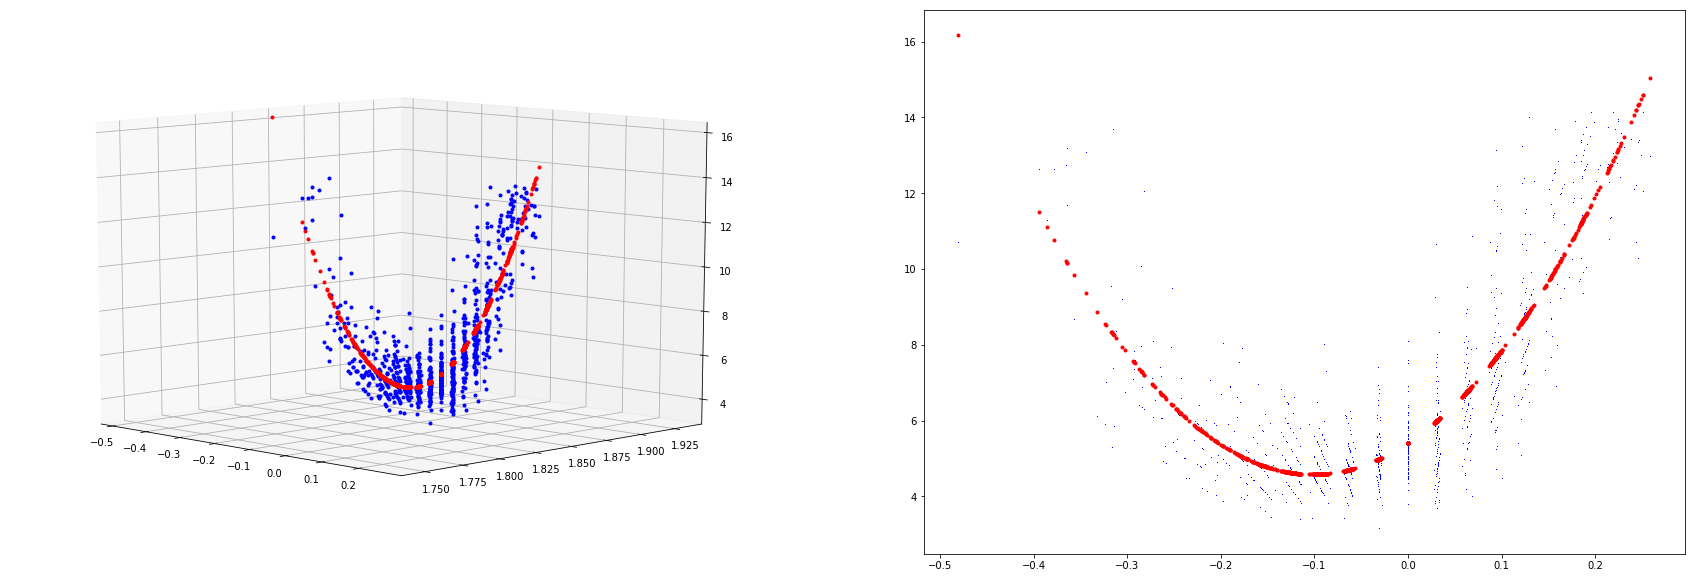

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(30, 10))

# 3d plot
ax = fig.add_subplot(121, projection='3d')
ax.view_init(10, -45)
ax.plot(gradient, totalup, pace, 'b.')
ax.plot(gradient, totalup, predictions, 'r.')

# 2d plot
ax = fig.add_subplot(122)
ax.plot(gradient, pace, 'b,')
ax.plot(gradient, predictions, 'r.')

plt.show()

## Estimate Flat Pace and Maximum Speed with Total Elevation Gain

**TODO**: explain formula


In [11]:
total_up_mean = totalup.mean()
length_mean = length.mean()

flat_param = model.intercept_
slope_squared_param, slope_param, totalup_param, length_param = model.coef_
flat_pace = (flat_param + totalup_param * total_up_mean + length_param * length_mean) * 1000 / 60


# flat and max pace and speed
print('flat pace:  %02d:%02d min/km' % (math.floor(flat_pace), int(round(flat_pace % 1 * 60, 0))))
print('flat speed: %.2f km/h' % (1/flat_pace * 60))
min_x = -slope_param / (2 * slope_squared_param)
max_speed = (slope_squared_param * min_x**2 + slope_param * min_x + flat_param + totalup_param * total_up_mean +length_param * length_mean) * 1000 / 60
print('max pace:   %02d:%02d min/km at %06.2f percent slope' % (math.floor(max_speed), int(round(max_speed % 1 * 60, 0)), min_x * 100))
print('max speed:  %.2f km/h at %06.2f percent slope' % (1/max_speed * 60, min_x * 100))

NameError: name 'length' is not defined

## Estimate Max Vertical Speed

**TODO**: explain formula


100 meters elevation gain in 14 minutes and 68 meters distance


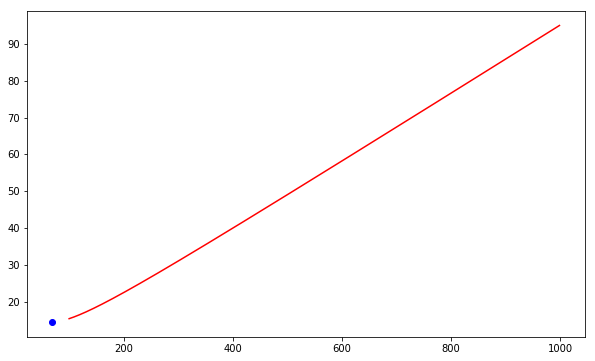

In [75]:
gain = 100
distance = np.arange(gain, gain*10)
seconds = (((slope_squared_param * (gain**2))/distance) + slope_param * gain + flat_param * distance + totalup_param * gain)/60 

min_distance = ((slope_squared_param * gain**2)/flat_param)**(1/2)
min_seconds = (((slope_squared_param * (gain**2))/min_distance) + slope_param * gain + flat_param * min_distance + totalup_param * gain)/60

print('%d meters elevation gain in %.0f minutes and %d meters distance' % (gain, min_seconds, min_distance))

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(distance,seconds,'r-')
ax.plot(min_distance, min_seconds,'bo')

## Calculate Schedule

In [ ]:
data = pd.read_json('route_data.json', orient='records')
totalup = data.iloc[-1,-1]
length = data.iloc[-1,2]

data['distance'] = data['length'].diff()
data = data[data['distance'] > 0]
data['gradient'] = data['altitude'].diff() / data['distance']
data['gradient_squared'] = data['gradient']**2

route_variables = data.loc[2:, ['gradient_squared', 'gradient']]
route_variables['totalup'] = totalup / 1000
route_variables['length'] = length / 1000

lm = LinearRegression()
lm.coef_ = model.coef_
lm.intercept_ = model.intercept_

route_variables['pace'] = lm.predict(route_variables)
route_variables['time'] = 


print('%s: %s' % (totalup, length))

route_variables